In [28]:
"""
import os
import tensorflow as tf

# 1) Define where to download & extract
local_data_dir = "D:/AIML/data/flower_photos"
os.makedirs(local_data_dir, exist_ok=True)

# 2) Download & extract the archive
URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive_path = tf.keras.utils.get_file(
    fname="flower_photos.tgz",
    origin=URL,
    extract=True,
    cache_dir=local_data_dir,
    cache_subdir=""
)

# 3) Point to the extracted directory
data_root = os.path.join(local_data_dir, "flower_photos")

# 4) List only subdirectories (i.e. the classes)
all_entries = sorted(os.listdir(data_root))
class_dirs = [d for d in all_entries if os.path.isdir(os.path.join(data_root, d))]

print("Classes found:", class_dirs)
print()

# 5) Show a few sample file names from the first 3 classes
for cls in class_dirs[:3]:
    cls_path = os.path.join(data_root, cls)
    sample_files = os.listdir(cls_path)[:5]
    print(f"  {cls} ({len(os.listdir(cls_path))} images): {sample_files}")
"""

'\nimport os\nimport tensorflow as tf\n\n# 1) Define where to download & extract\nlocal_data_dir = "D:/AIML/data/flower_photos"\nos.makedirs(local_data_dir, exist_ok=True)\n\n# 2) Download & extract the archive\nURL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"\narchive_path = tf.keras.utils.get_file(\n    fname="flower_photos.tgz",\n    origin=URL,\n    extract=True,\n    cache_dir=local_data_dir,\n    cache_subdir=""\n)\n\n# 3) Point to the extracted directory\ndata_root = os.path.join(local_data_dir, "flower_photos")\n\n# 4) List only subdirectories (i.e. the classes)\nall_entries = sorted(os.listdir(data_root))\nclass_dirs = [d for d in all_entries if os.path.isdir(os.path.join(data_root, d))]\n\nprint("Classes found:", class_dirs)\nprint()\n\n# 5) Show a few sample file names from the first 3 classes\nfor cls in class_dirs[:3]:\n    cls_path = os.path.join(data_root, cls)\n    sample_files = os.listdir(cls_path)[:5]\n    print(f"  {cls

In [29]:
# Step 0: Imports & Constants
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

In [30]:
# Adjust these if you moved data elsewhere
DATA_ROOT    = "D:/AIML/data/flower_photos/flower_photos"
Save_Root    = "D:/AIML/data/flower_photos/"
IMG_HEIGHT   = 180
IMG_WIDTH    = 180
BATCH_SIZE   = 32
AUTOTUNE     = tf.data.AUTOTUNE

In [31]:
# Step 1: Inspect folder structure & classes
class_dirs = [d for d in sorted(os.listdir(DATA_ROOT))
              if os.path.isdir(os.path.join(DATA_ROOT, d))]
print("Found classes:", class_dirs)

# Print counts per class
for cls in class_dirs:
    n = len(os.listdir(os.path.join(DATA_ROOT, cls)))
    print(f"  {cls:12s}: {n} images")

Found classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  daisy       : 633 images
  dandelion   : 898 images
  roses       : 641 images
  sunflowers  : 699 images
  tulips      : 799 images


In [32]:
# Step 2: Build train/validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="int"
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="int"
)

NUM_CLASSES = len(train_ds.class_names)
class_names = train_ds.class_names
print("Classes:", class_names, "Num of classes :", NUM_CLASSES)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] Num of classes : 5


In [33]:
# Step 3: Preprocessing & Augmentation layers
preprocess_input = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
], name="data_augmentation")


In [34]:
# Step 4: Prepare tf.data pipelines
def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000, seed=42)
    ds = ds.map(lambda x, y: (preprocess_input(x), y), 
                num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds   = prepare(val_ds)


In [35]:
# # Step 5: Build the Functional‑API CNN
# inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input_image")

# x = data_augmentation(inputs)         # optional augmentation in-model
# x = preprocess_input(x)               # normalize

# x = layers.Conv2D(32, 3, activation="relu")(x)
# x = layers.MaxPooling2D()(x)

# x = layers.Conv2D(64, 3, activation="relu")(x)
# x = layers.MaxPooling2D()(x)

# x = layers.Conv2D(128, 3, activation="relu")(x)
# x = layers.MaxPooling2D()(x)

# x = layers.Flatten()(x)
# x = layers.Dense(256, activation="relu")(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

# model = Model(inputs, outputs, name="flower_cnn")
# model.summary()


In [36]:
# Step 5: Build the Functional‑API CNN
# Revised model (with BatchNorm and extra conv)
inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, 3), name="input_image")
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

for filters in [32, 64, 128, 256]:
    x = layers.Conv2D(filters, 3, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 180, 180, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 180, 180, 3)       0         
 ial)                                                            
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0     

In [37]:
# Step 6: Compile & Callbacks
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f"{Save_Root}flowers_best.h5", save_best_only=True, monitor="val_accuracy"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
    ),
    tf.keras.callbacks.TensorBoard(log_dir=f"{Save_Root}logs/flower_cnn", histogram_freq=1)
]


In [38]:
# Step 7: Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
92/92 [==============================] - 115s 1s/step - loss: 7.1683 - accuracy: 0.3716 - val_loss: 1.6504 - val_accuracy: 0.2602 - lr: 0.0010
Epoch 2/10
92/92 [==============================] - 105s 1s/step - loss: 1.4308 - accuracy: 0.3965 - val_loss: 1.8991 - val_accuracy: 0.2602 - lr: 0.0010
Epoch 3/10
92/92 [==============================] - 105s 1s/step - loss: 1.3313 - accuracy: 0.4125 - val_loss: 1.8291 - val_accuracy: 0.2602 - lr: 0.0010
Epoch 4/10
92/92 [==============================] - 114s 1s/step - loss: 1.2852 - accuracy: 0.4384 - val_loss: 2.0741 - val_accuracy: 0.2602 - lr: 5.0000e-04


In [39]:
# Step 8: Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")


23/23 [==============================] - 6s 252ms/step - loss: 1.6504 - accuracy: 0.2602
Validation Accuracy: 0.2602


1/1 [==============================] - 0s 353ms/step


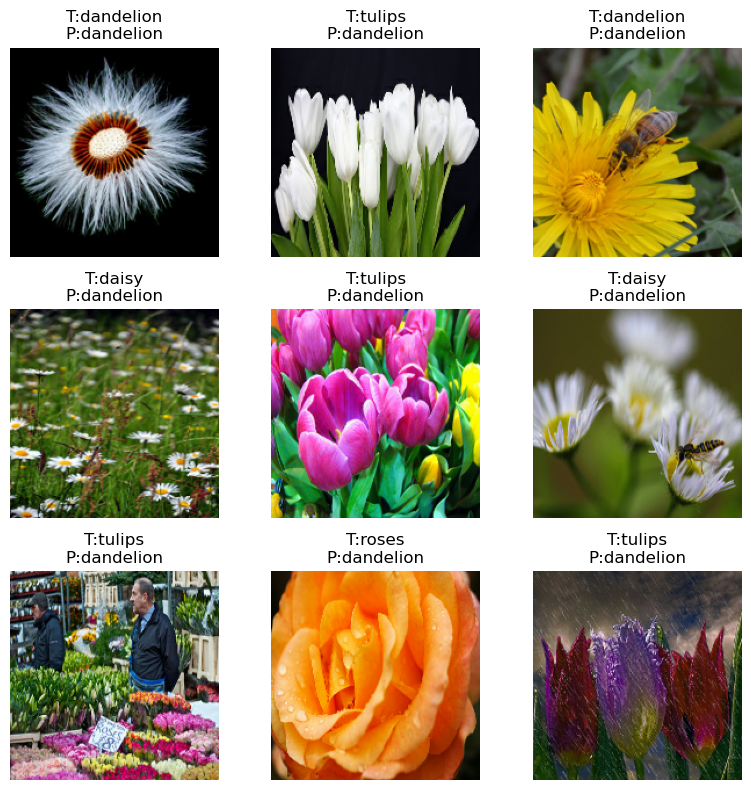

In [40]:
# Step 9: Visualize a few predictions
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1).numpy()

    plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        # Use the standalone class_names, not train_ds.class_names
        plt.title(f"T:{class_names[labels[i]]}\nP:{class_names[pred_labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break
